# Обучение мультимодальной модель (Image -> Text)

In [1]:
!python -V

import io
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
from PIL import Image
from datasets import load_dataset

import warnings
for warn in [UserWarning, FutureWarning]: warnings.filterwarnings("ignore", category = warn)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Python 3.13.3
Using device: cpu


In [2]:
class LogoDataset(Dataset):
    def __init__(self, dataset, transform=None):
        self.dataset = dataset
        self.transform = transform
        self.vocab = self._build_vocab()

    def _build_vocab(self):
        vocab = {"<PAD>": 0, "<SOS>": 1, "<EOS>": 2, "<UNK>": 3}
        for item in self.dataset:
            tokens = self._tokenize_text(item["text"])
            for token in tokens:
                if token not in vocab:
                    vocab[token] = len(vocab)
        return vocab

    def _tokenize_text(self, text):
        return text.lower().split()

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        item = self.dataset[idx]

        if isinstance(item["image"], bytes):
            image = Image.open(io.BytesIO(item["image"])).convert("RGB")
        elif isinstance(item["image"], str):
            image = Image.open(item["image"]).convert("RGB")
        else:
            image = item["image"]  # Если уже PIL.Image

        if self.transform:
            image = self.transform(image)

        text = item["text"]
        tokens = [self.vocab["<SOS>"]] + \
                [self.vocab.get(t, self.vocab["<UNK>"]) for t in self._tokenize_text(text)] + \
                [self.vocab["<EOS>"]]

        return image, torch.tensor(tokens)

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

def collate_fn(batch):
    images = [item[0] for item in batch]
    captions = [item[1] for item in batch]

    images = torch.stack(images, dim=0)

    max_len = max(len(cap) for cap in captions)
    padded_captions = torch.zeros(len(captions), max_len, dtype=torch.long)
    for i, cap in enumerate(captions):
        padded_captions[i, :len(cap)] = cap

    return images, padded_captions


In [3]:
dataset = load_dataset("mirandal/image_descriptions_cleaned", split="train")
full_dataset = LogoDataset(dataset, transform=transform)

print(dataset)

Dataset({
    features: ['image', 'text'],
    num_rows: 1000
})


In [4]:
BATCH_SIZE = 32

train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    collate_fn=collate_fn
)
val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    collate_fn=collate_fn
)

In [5]:
LR = 1e-3
EMBEDDING_DIM = 256
HIDDEN_DIM = 512

class EncoderCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(3, 64, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(64, 128, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(128, 256, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.AdaptiveAvgPool2d((1, 1)))

    def forward(self, x):
        return self.cnn(x).squeeze(-1).squeeze(-1)  # [batch, 256]

class DecoderRNN(nn.Module):
    def __init__(self, vocab_size, hidden_size, embedding_dim):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, vocab_size)

    def forward(self, x, hidden=None):
        # x: [batch, seq_len]
        embedded = self.embedding(x)  # [batch, seq_len, embedding_dim]

        if hidden is None:
            batch_size = x.size(0)
            h0 = torch.zeros(1, batch_size, self.lstm.hidden_size).to(x.device)
            c0 = torch.zeros(1, batch_size, self.lstm.hidden_size).to(x.device)
            hidden = (h0, c0)

        output, hidden = self.lstm(embedded, hidden)  # output: [batch, seq_len, hidden_size]
        output = self.fc(output)  # [batch, seq_len, vocab_size]
        return output, hidden

class ImageCaptionModel(nn.Module):
    def __init__(self, vocab_size):
        super().__init__()
        self.encoder = EncoderCNN()
        self.decoder = DecoderRNN(vocab_size, HIDDEN_DIM, EMBEDDING_DIM)

    def forward(self, images, captions):
        """
        images: [batch, 3, 224, 224]
        captions: [batch, max_len]
        """
        features = self.encoder(images)  # [batch, 256]
        features = features.unsqueeze(1)  # [batch, 1, 256]
        outputs, _ = self.decoder(captions[:, :-1])  # outputs: [batch, seq_len-1, vocab_size]
        return outputs

model = ImageCaptionModel(vocab_size=len(full_dataset.vocab)).to(device)
optimizer = optim.Adam(model.parameters(), lr=LR)
criterion = nn.CrossEntropyLoss(ignore_index=0)


In [6]:
EPOCHS = 50

for epoch in range(EPOCHS):
    model.train()
    total_loss = 0
    for images, captions in train_loader:
        images, captions = images.to(device), captions.to(device)

        optimizer.zero_grad()
        outputs = model(images, captions)

        loss = criterion(
            outputs.view(-1, outputs.size(-1)),
            captions[:, 1:].reshape(-1)
        )

        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    print(f"Epoch {epoch+1}, Loss: {total_loss/len(train_loader):.4f}")


Epoch 1, Loss: 6.4933
Epoch 2, Loss: 5.1822
Epoch 3, Loss: 4.7457
Epoch 4, Loss: 4.4049
Epoch 5, Loss: 4.1224
Epoch 6, Loss: 3.8853
Epoch 7, Loss: 3.6724
Epoch 8, Loss: 3.4795
Epoch 9, Loss: 3.2974
Epoch 10, Loss: 3.1284
Epoch 11, Loss: 2.9698
Epoch 12, Loss: 2.8177
Epoch 13, Loss: 2.6759
Epoch 14, Loss: 2.5340
Epoch 15, Loss: 2.3957
Epoch 16, Loss: 2.2671
Epoch 17, Loss: 2.1433
Epoch 18, Loss: 2.0243
Epoch 19, Loss: 1.9155
Epoch 20, Loss: 1.8049
Epoch 21, Loss: 1.7039
Epoch 22, Loss: 1.6106
Epoch 23, Loss: 1.5285
Epoch 24, Loss: 1.4444
Epoch 25, Loss: 1.3622
Epoch 26, Loss: 1.2822
Epoch 27, Loss: 1.2067
Epoch 28, Loss: 1.1381
Epoch 29, Loss: 1.0758
Epoch 30, Loss: 1.0130
Epoch 31, Loss: 0.9535
Epoch 32, Loss: 0.8985
Epoch 33, Loss: 0.8494
Epoch 34, Loss: 0.8015
Epoch 35, Loss: 0.7575
Epoch 36, Loss: 0.7155
Epoch 37, Loss: 0.6744
Epoch 38, Loss: 0.6358
Epoch 39, Loss: 0.5987
Epoch 40, Loss: 0.5651
Epoch 41, Loss: 0.5348
Epoch 42, Loss: 0.5070
Epoch 43, Loss: 0.4799
Epoch 44, Loss: 0.45

In [7]:
def generate_caption(model, image, vocab, max_length=20):
    model.eval()
    if isinstance(image, str):
        image = Image.open(image).convert("RGB")
    image = transform(image).unsqueeze(0).to(device)

    features = model.encoder(image)
    features = features.unsqueeze(1)
    hidden = None

    input_word = torch.tensor([vocab["<SOS>"]]).to(device)
    caption = []

    for _ in range(max_length):
        output, hidden = model.decoder(input_word.unsqueeze(0), hidden)
        predicted_word = output.argmax(-1).item()

        if predicted_word == vocab["<EOS>"]:
            break

        caption.append(predicted_word)
        input_word = torch.tensor([predicted_word]).to(device)

    idx_to_word = {v: k for k, v in vocab.items()}
    return " ".join([idx_to_word.get(idx, "<UNK>") for idx in caption])

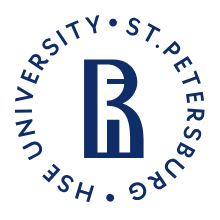

the logo features a stylized letter 'g' in black set against a white background within a square border. the design


In [8]:
from IPython.display import display, Image as IPImage

test_image_path = "test_logo.png"
display(IPImage(filename=test_image_path, width=300))
print(generate_caption(model, test_image_path, full_dataset.vocab))

Выводы:
- Модель обучается и генерирует текст учитывая изоброжение логотипа, но хорошо бы обучить её на большем количестве изображений логотипов дав больше времени на обучение и вариации изображений.
- Видно упоминание ключевых слов, связанных с логотипами. 